In [1]:
import os
import json
import psycopg2
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
import folium
import fiona
from pyproj import Proj, transform
import osmnx as ox
import networkx as nx
import matplotlib.colors as colors
import matplotlib.cm as cm

In [2]:
nx.__version__

'2.0'

In [3]:

ox.config(log_file=True, log_console=True, use_cache=True)

## Graph from polygon - Rapperswil

In [4]:
rapperswil_polygon_query = "SELECT ST_GeomFromText(' POLYGON((8.8094571514 47.2300693781, 8.8264730854 47.2300693781, 8.8264730854 47.2212240649, 8.8094571514 47.2212240649, 8.8094571514 47.2300693781))') AS geometry"

with psycopg2.connect("") as conn:
    polygon_gdf = gpd.read_postgis(rapperswil_polygon_query, conn, geom_col='geometry')
    polygon_gdf.crs = fiona.crs.from_epsg('4326')
    polygon_gdf = polygon_gdf.to_crs(fiona.crs.from_epsg('4326'))
    polygon = polygon_gdf['geometry'][0]

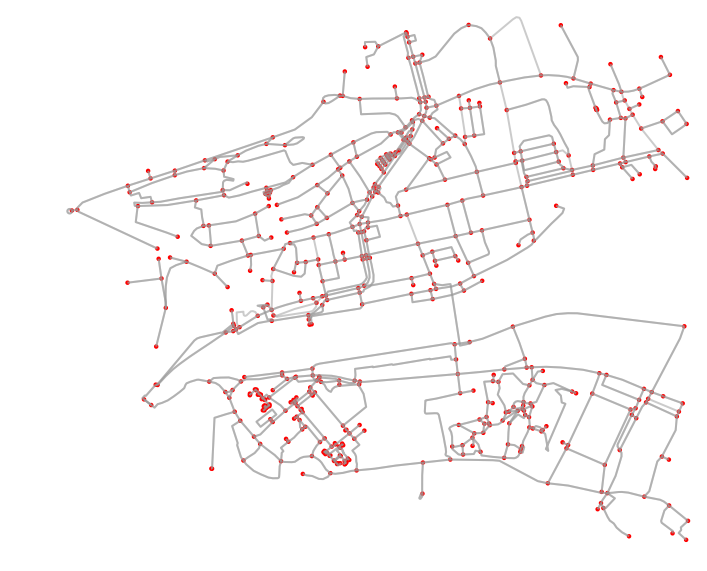

In [5]:
rapperswil_graph = ox.graph_from_polygon(polygon, network_type='all')
rapperswil_graph_projected = ox.project_graph(rapperswil_graph)
fig, ax = ox.plot_graph(rapperswil_graph_projected,fig_height=10, edge_linewidth=2, node_size=20, node_color="red", edge_alpha=0.5)

In [6]:
ox.plot_graph_folium(rapperswil_graph, popup_attribute='name', edge_width=2)

## Graph from bounding box - Rapperswil

In [7]:
# define a bounding box of Rapperswil Altstadt
west, south, east, north = 8.8130341262,47.2231736868,8.826466629,47.2278149394
# west, south, east, north = 8.526596,47.363524,8.552174,47.382531 # Zürich small
#west, south, east, north = 8.448006,47.320221,8.625442,47.434666 # Zürich big
G = ox.graph_from_bbox(north, south, east, west, network_type='all')
ox.plot_graph_folium(G, popup_attribute='name', edge_width=2)

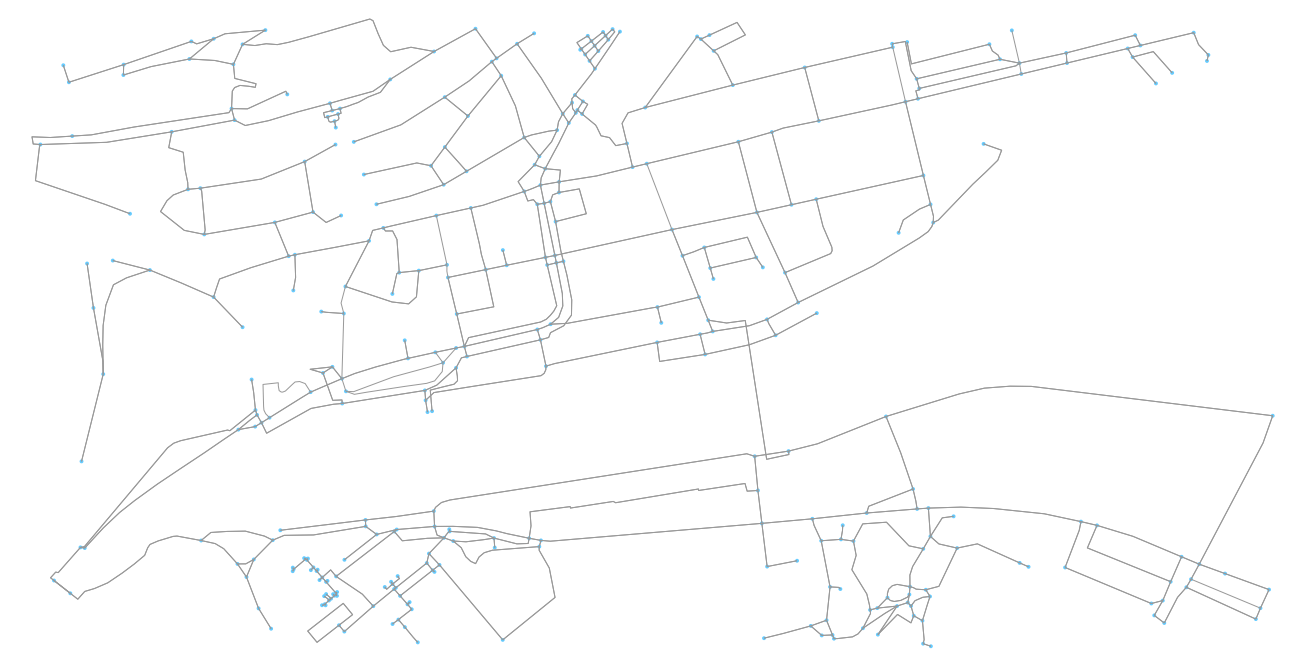

In [8]:
fig, ax = ox.plot_graph(ox.project_graph(G), fig_height=12)

In [6]:
G = rapperswil_graph

In [7]:
node_centrality = nx.closeness_centrality(G)

In [8]:
node_centrality

{29773941: 0.08422500764292265,
 29773948: 0.054962593516209475,
 32166330: 0.06353049694454053,
 32166334: 0.06661830492080764,
 32166358: 0.06169521890045908,
 32166382: 0.06223878911103581,
 32166393: 0.053417353368880274,
 32166396: 0.050713299585826044,
 32167231: 0.07851239669421488,
 32167238: 0.08569206842923795,
 32167740: 0.04609721408851335,
 32167743: 0.044847794237343315,
 32167761: 0.048808574718752766,
 32167782: 0.0559163791353765,
 32167856: 0.05747366225096485,
 32860913: 0.07359422999866436,
 32860918: 0.08895705521472393,
 32860925: 0.08574540927482104,
 59125785: 0.09114971050454922,
 59125792: 0.08335854765506807,
 59125797: 0.07365325491244486,
 59125808: 0.06995937023869984,
 59126210: 0.05273736600306279,
 59139658: 0.05129398622230497,
 59139691: 0.06916896811448657,
 59139699: 0.06723611958511287,
 59139711: 0.06655393163425534,
 59139742: 0.0555387561737728,
 59139745: 0.05374036867258363,
 59903248: 0.04694955691888207,
 59903255: 0.04924039320822163,
 5990

In [9]:
edge_centrality = nx.closeness_centrality(nx.line_graph(G))

In [10]:
edge_centrality

{(29773941, 2242467578, 0): 0.08126698840627947,
 (2242467578, 2571875221, 0): 0.08217410814449182,
 (2242467578, 2571875220, 0): 0.08217410814449182,
 (2242467578, 29773941, 0): 0.08217410814449182,
 (2242467578, 32860918, 0): 0.08217410814449182,
 (29773941, 2025719919, 0): 0.08126698840627947,
 (2025719919, 2571875218, 0): 0.07972355245973008,
 (2025719919, 29773941, 0): 0.07972355245973008,
 (2025719919, 287636860, 0): 0.07972355245973008,
 (2025719919, 310805714, 0): 0.07972355245973008,
 (29773941, 2242467582, 0): 0.08126698840627947,
 (2242467582, 29773941, 0): 0.0768665722230967,
 (2242467582, 2631128441, 0): 0.0768665722230967,
 (2242467582, 2571875216, 0): 0.0768665722230967,
 (2242467582, 2571875221, 0): 0.0768665722230967,
 (29773941, 287636860, 0): 0.08126698840627947,
 (287636860, 2571875216, 0): 0.0794684024952536,
 (287636860, 29773941, 0): 0.0794684024952536,
 (287636860, 287637814, 0): 0.0794684024952536,
 (287636860, 2025719919, 0): 0.0794684024952536,
 (29773948, 34

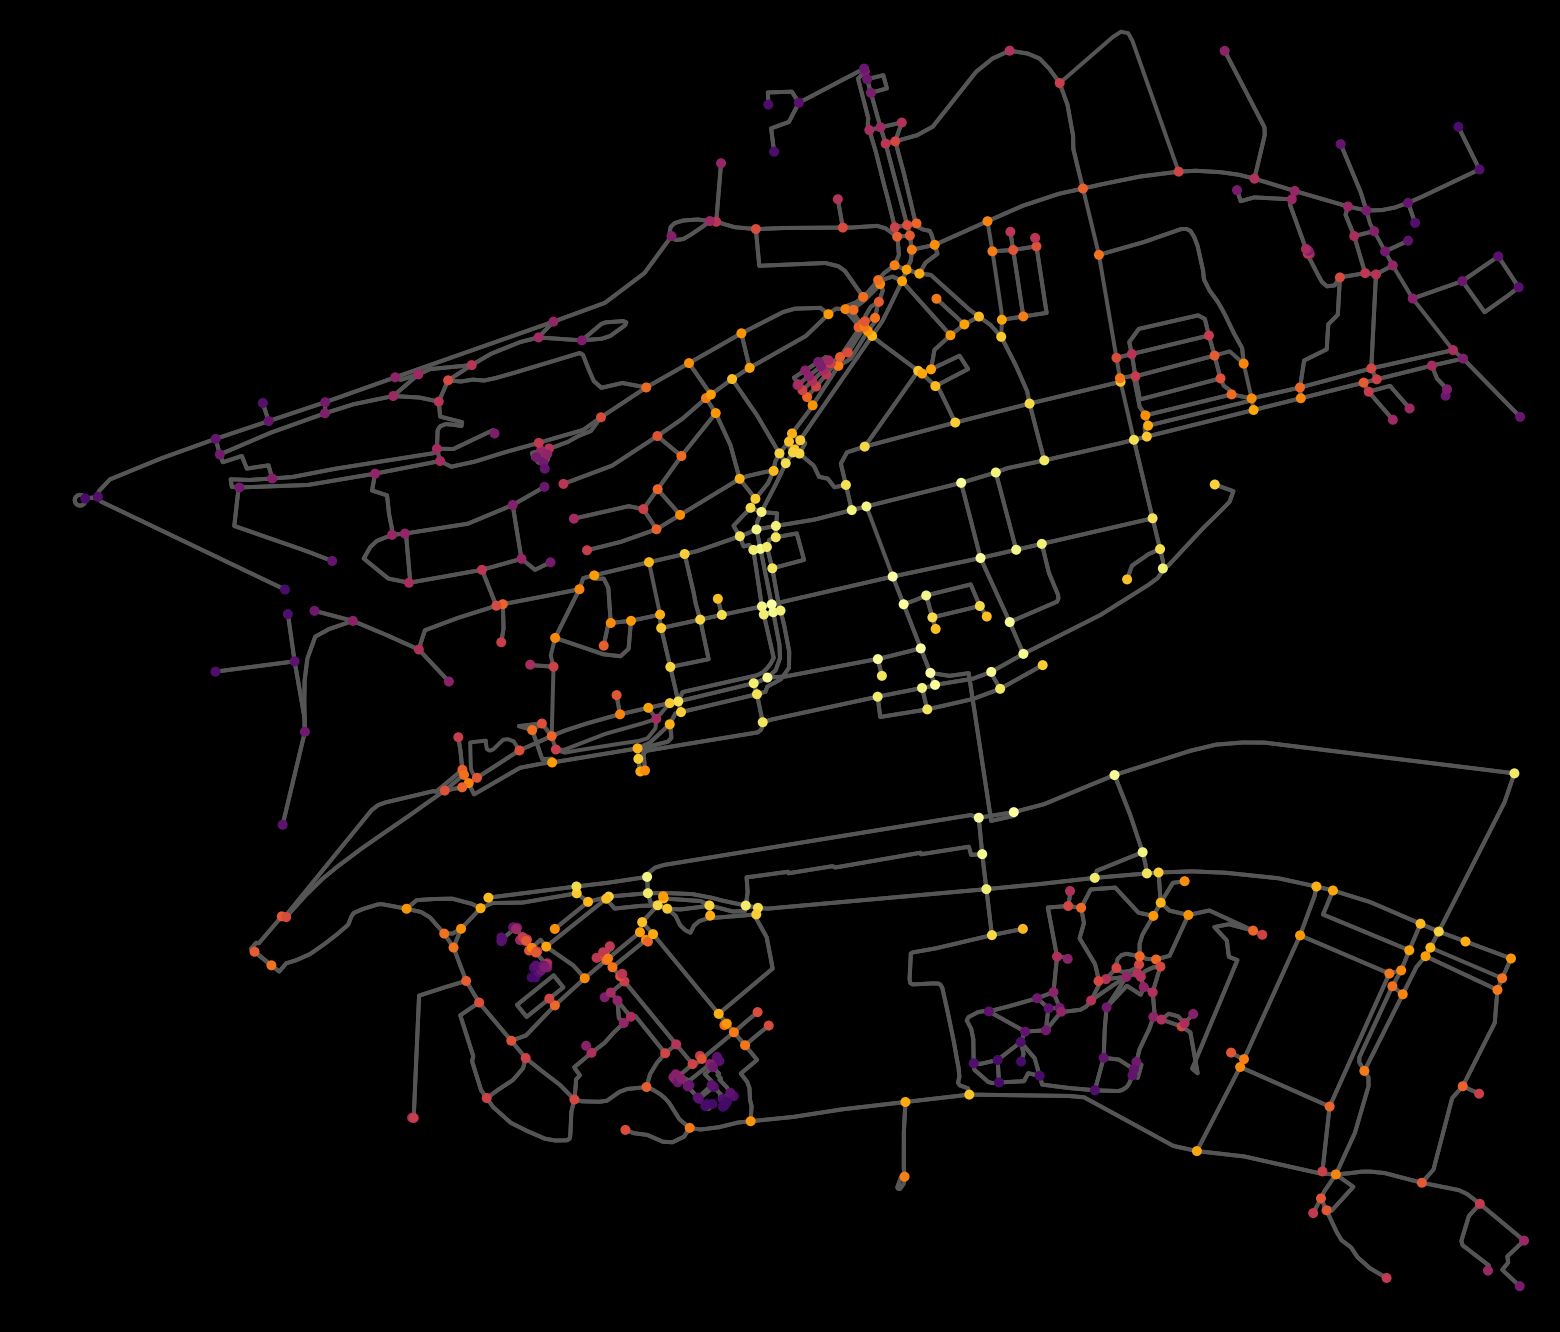

In [15]:
# plot it
df = pd.DataFrame(data=pd.Series(node_centrality).sort_values(), columns=['cc'])
df['colors'] = ox.get_colors(n=len(df), cmap='inferno', start=0.2)
df = df.reindex(G.nodes())
nc = df['colors'].tolist()
fig, ax = ox.plot_graph(G, bgcolor='k', node_size=100, node_color=nc, node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=4, edge_alpha=1, fig_height=24)

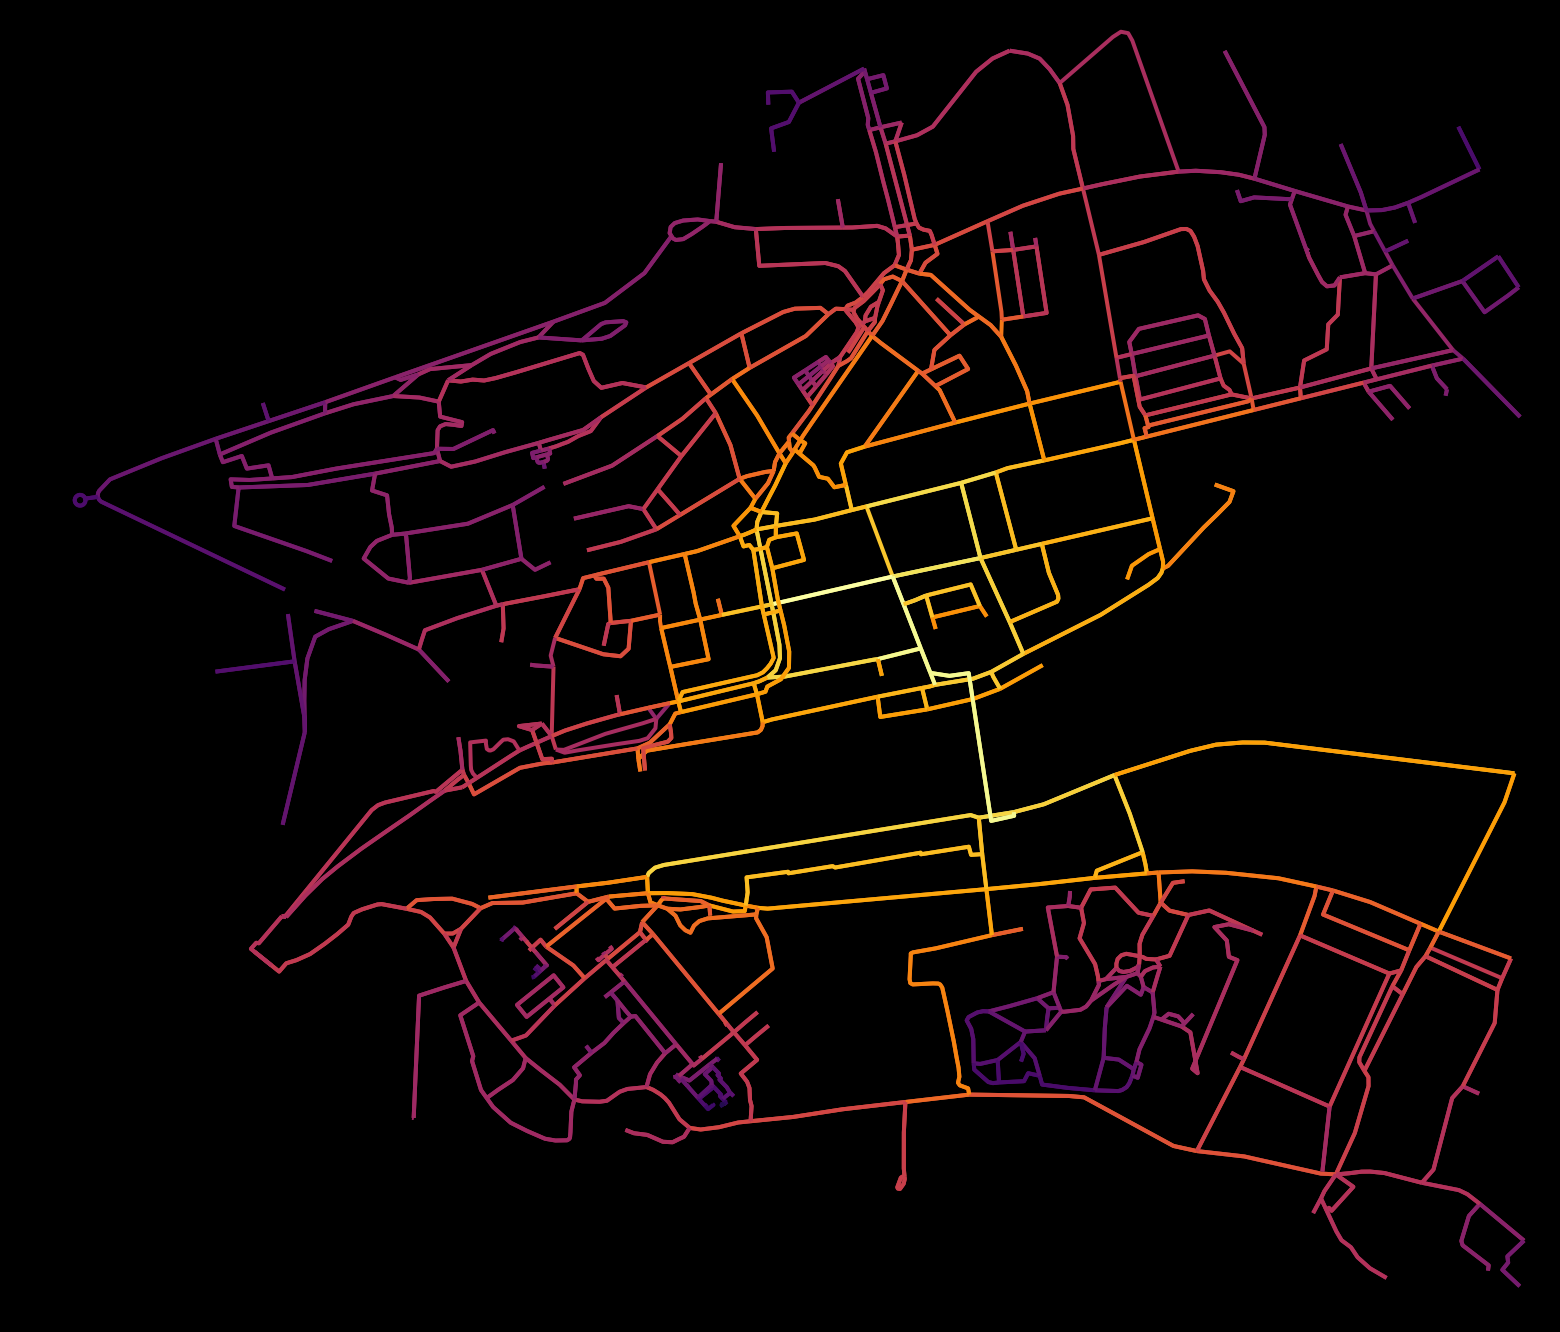

In [14]:
# edge closeness centrality: convert graph to a line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(G))

# list of edge values for the orginal graph
ev = [edge_centrality[edge + (0,)] for edge in G.edges()]

# color scale converted to list of colors for graph edges
norm = colors.Normalize(vmin=min(ev)*0.8, vmax=max(ev))
cmap = cm.ScalarMappable(norm=norm, cmap=cm.inferno)
ec = [cmap.to_rgba(cl) for cl in ev]

# color the edges in the original graph with closeness centralities in the line graph
fig, ax = ox.plot_graph(G, bgcolor='k', axis_off=True, node_size=0, node_color='w', node_edgecolor='gray', node_zorder=2,
                        edge_color=ec, edge_linewidth=4, edge_alpha=1, fig_height=24)

In [24]:
ox.plot_graph_folium(G, edge_color=ec)
